In [73]:
# import comet_ml at the top of your file
from comet_ml import Experiment
experiment = Experiment(
            project_name="music-genre-multiclass-classification",
            workspace="wodenwang820118",
        )
import comet_ml
import logging

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/633a12182fd6494e96d0b7d7736a4548



In [74]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger("comet_ml")

In [75]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# the api for grid search the model hyperparameters
from comet_ml import Experiment
import json

os.environ["GRPC_FAIL_FAST"] = "use_caller"
pd.set_option('display.max_columns', None)

In [76]:
# tensorflow 2.7 
import tensorflow as tf 
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model

In [77]:
df_train_features = pd.read_csv('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

df_valid_features = pd.read_csv('valid_features.csv')
df_valid_labels = pd.read_csv('valid_labels.csv')

df_test_features = pd.read_csv('test_features.csv')

In [78]:
def str_remove_comma(string):
    str = string.split(", ")
    return str

def list_to_string(list):
    str = " "
    return str.join(list)

In [79]:
x_train = df_train_features['tags'].apply(lambda x : list_to_string(str_remove_comma(x)))
y_train = df_train_labels['genre'].to_numpy()

x_test = df_valid_features['tags'].apply(lambda x : list_to_string(str_remove_comma(x)))
y_test = df_valid_labels['genre'].to_numpy()

In [80]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [81]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train_labels['genre']),y=df_train_labels['genre'])
class_weight = {i :class_weight[i] for i in range(8)}

In [82]:
import ktrain
from ktrain import text

In [83]:
class TextGenreClassifier:
    def __init__(self,x_train,y_train,x_text,y_text,class_weight,experiment):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_text
        self.y_test = y_text
        self.class_weight = class_weight
        self.experiment = experiment
    
    def build_model(self):
        trn, val, preproc = text.texts_from_array(
            x_train=self.x_train, y_train=self.y_train,
            x_test=self.x_test, y_test=self.y_test,
            class_names = np.unique(df_train_labels['genre']),
            ngram_range=self.experiment.get_parameter("ngram_range"), 
            maxlen=self.experiment.get_parameter("maxlen"), 
            preprocess_mode='standard'
        )
        model = text.text_classifier('fasttext', train_data=trn, preproc=preproc, metrics=['accuracy'])
        return model, trn, val
    
    def train_model(self):
        # Train the model
        model, trn, val = self.build_model()
        learner = ktrain.get_learner(
            model,
            train_data=trn,
            val_data=val,
            batch_size=self.experiment.get_parameter("batch_size"))
        learner.fit_onecycle(
            lr=0.001,
            epochs=self.experiment.get_parameter("epochs"),
            class_weight=self.class_weight
        )
        return learner, val
    
    def evaluate_model(self):
        # Evaluate the model
        learner, val = self.train_model()
        score = learner.evaluate(test_data=val)
        LOGGER.info(f"{ score }")
    
    def grid_search(self, config_dict):
        opt = comet_ml.Optimizer(config_dict)
        for self.experiment in opt.get_experiments(project_name="music-genre-multiclass-classification"):
            self.build_model()
            self.train_model()
            self.evaluate_model()
            self.experiment.end()

In [84]:
textGenreClassifier = TextGenreClassifier(x_train,y_train,x_test,y_test,class_weight,experiment)

In [85]:
textGenreClassifier.grid_search({
    "algorithm": "bayes",
    "name": "Optimize Music Classification Network",
    "spec": {"maxCombo": 10, "objective": "minimize", "metric": "loss"},
    "parameters": {
        "ngram_range": {"type": "discrete", "values": [1]},
        "maxlen": {"type": "discrete", "values": [150]},
        "epochs": {"type": "discrete", "values": [20,25,30,35]},
        "batch_size": {"type": "discrete", "values": [16, 32]},
    },
    "trials": 1,
})

COMET INFO: COMET_OPTIMIZER_ID=27e8760acfc64696bbc00fbb78b1b668
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 8, 'endTime': None, 'id': '27e8760acfc64696bbc00fbb78b1b668', 'lastUpdateTime': None, 'maxCombo': 10, 'name': 'Optimize Music Classification Network', 'parameters': {'batch_size': {'type': 'discrete', 'values': [16, 32]}, 'epochs': {'type': 'discrete', 'values': [20, 25, 30, 35]}, 'maxlen': {'type': 'discrete', 'values': [150]}, 'ngram_range': {'type': 'discrete', 'values': [1]}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 10, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 26833643135, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}
COMET INFO: ---------------------------
COMET INFO: Comet.ml

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE




begin training using onecycle policy with max lr of 0.001...
Epoch 1/30


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


480/480 [==============================] - 5s 9ms/step - loss: 2.5046 - accuracy: 0.1278 - val_loss: 2.0334 - val_accuracy: 0.3200
Epoch 2/30
480/480 [==============================] - 5s 10ms/step - loss: 2.3260 - accuracy: 0.1539 - val_loss: 1.8217 - val_accuracy: 0.4178
Epoch 3/30
480/480 [==============================] - 5s 10ms/step - loss: 2.2034 - accuracy: 0.1709 - val_loss: 1.7331 - val_accuracy: 0.4156
Epoch 4/30
480/480 [==============================] - 5s 10ms/step - loss: 2.1062 - accuracy: 0.1999 - val_loss: 1.6747 - val_accuracy: 0.4556
Epoch 5/30
480/480 [==============================] - 5s 10ms/step - loss: 2.0095 - accuracy: 0.2169 - val_loss: 1.6081 - val_accuracy: 0.5000
Epoch 6/30
480/480 [==============================] - 5s 10ms/step - loss: 1.9371 - accuracy: 0.2454 - val_loss: 1.5572 - val_accuracy: 0.5111
Epoch 7/30
480/480 [==============================] - 5s 9ms/step - loss: 1.8748 - accuracy: 0.2647 - val_loss: 1.5174 - val_accuracy: 0.4911
Epoch 8/30
4

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')




begin training using onecycle policy with max lr of 0.001...
Epoch 1/30
480/480 [==============================] - 5s 10ms/step - loss: 2.4860 - accuracy: 0.1326 - val_loss: 2.0309 - val_accuracy: 0.3200
Epoch 2/30
480/480 [==============================] - 4s 9ms/step - loss: 2.3490 - accuracy: 0.1457 - val_loss: 1.8265 - val_accuracy: 0.3556
Epoch 3/30
480/480 [==============================] - 4s 9ms/step - loss: 2.1851 - accuracy: 0.1734 - val_loss: 1.7314 - val_accuracy: 0.3889
Epoch 4/30
480/480 [==============================] - 4s 9ms/step - loss: 2.1112 - accuracy: 0.1904 - val_loss: 1.6604 - val_accuracy: 0.3956
Epoch 5/30
480/480 [==============================] - 4s 9ms/step - loss: 2.0193 - accuracy: 0.2064 - val_loss: 1.6166 - val_accuracy: 0.4667
Epoch 6/30
480/480 [==============================] - 4s 9ms/step - loss: 1.9468 - accuracy: 0.2411 - val_loss: 1.5478 - val_accuracy: 0.4956
Epoch 7/30
480/480 [==============================] - 4s 9ms/step - loss: 1.8809 - a

COMET INFO: [[10  6  8 11  2  0  3 15]
 [ 7  9  9  7  2  2  5  4]
 [ 8  4 43  3  3  0  0  3]
 [11  4 10  8  4  2  3  2]
 [ 3  3  5  2 36  1 10  6]
 [ 0  0  0  0  0 72  2  0]
 [ 2  5  2  1  2  0 32  0]
 [10  9  3  2  0  2  0 32]]


              precision    recall  f1-score   support

           0       0.20      0.18      0.19        55
           1       0.23      0.20      0.21        45
           2       0.54      0.67      0.60        64
           3       0.24      0.18      0.21        44
           4       0.73      0.55      0.63        66
           5       0.91      0.97      0.94        74
           6       0.58      0.73      0.65        44
           7       0.52      0.55      0.53        58

    accuracy                           0.54       450
   macro avg       0.49      0.50      0.49       450
weighted avg       0.53      0.54      0.53       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/572ab964d553492a994858f0daf26fa0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [60]                 : (0.1277676522731781, 0.5518364310264587)
COMET INFO:     batch_accuracy [2880]         : (0.0625, 0.6875)
COMET INFO:     batch_loss [2880]             : (0.7120789289474487, 2.7311208248138428)
COMET INFO:     epoch_duration [60]           : (3.8280000000013388, 5.2810000000026776)
COMET INFO:     loss [60]                     : (1.0727695226669312, 2.5046226978302)
COMET INFO:     val_accuracy [60]             : (0.3199999928474426, 0.5533333420753479)
COMET INFO:     val_loss [60]                 : (1.3068472146987915, 2.0334370136260986)
COMET INFO:     validate_batch_a

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')



done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/20
240/240 [==============================] - 3s 10ms/step - loss: 2.6055 - accuracy: 0.1434 - val_loss: 2.0728 - val_accuracy: 0.2422
Epoch 2/20
240/240 [==============================] - 2s 9ms/step - loss: 2.4111 - accuracy: 0.1521 - val_loss: 2.0049 - val_accuracy: 0.2933
Epoch 3/20
240/240 [==============================] - 2s 10ms/step - loss: 2.2565 - accuracy: 0.1693 - val_loss: 1.8007 - val_accuracy: 0.3911
Epoch 4/20
240/240 [==============================] 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/20
240/240 [==============================] - 3s 10ms/step - loss: 2.5608 - accuracy: 0.1328 - val_loss: 2.0703 - val_accuracy: 0.2756
Epoch 2/20
240/240 [==============================] - 2s 9ms/step - loss: 2.3724 - accuracy: 0.1481 - val_loss: 1.9966 - val_accuracy: 0.3356
Epoch 3/20
240/240 [==============================] - 2s 9ms/step - loss: 2.2164 - accuracy: 0.1698 - val_loss: 1.7800 - val_accuracy: 0.3911
Epoch 4/20
240/240 [==============================] - 2s 9ms/step - loss: 2.1097 - accuracy: 0.1960 - val_loss: 1.6878 - val_accuracy: 0.4222
Epoch 5/20
240/240 [==============================] - 2s 9ms/step - loss: 2.0234 - accuracy: 0.2236 - val_loss: 1.6396 - val_accuracy: 0.4489
Epoch 6/20
240/240 [==============================] - 2s 9ms/step - loss: 1.9302 - accuracy: 0.2449 - val_loss: 1.5888 - val_accuracy: 0.4711
Epoch 7/20
240/240 [==============================] - 2s 9ms/step - loss: 1.84

COMET INFO: [[ 5  5  3 26  1  0  0 15]
 [ 4 10  5 11  3  0  5  7]
 [ 8  5 27 13  3  1  0  7]
 [ 7  4  7 12  8  1  1  4]
 [ 2  7  1  1 37  1 12  5]
 [ 0  0  0  0  0 71  3  0]
 [ 1  4  0  3  3  0 33  0]
 [ 2 11  2  5  0  0  1 37]]


              precision    recall  f1-score   support

           0       0.17      0.09      0.12        55
           1       0.22      0.22      0.22        45
           2       0.60      0.42      0.50        64
           3       0.17      0.27      0.21        44
           4       0.67      0.56      0.61        66
           5       0.96      0.96      0.96        74
           6       0.60      0.75      0.67        44
           7       0.49      0.64      0.56        58

    accuracy                           0.52       450
   macro avg       0.49      0.49      0.48       450
weighted avg       0.52      0.52      0.51       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/3525b99abb8d43eabb871e3cfd00e419
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [40]                : (0.13284710049629211, 0.4593644142150879)
COMET INFO:     batch_accuracy [960]         : (0.0625, 0.6875)
COMET INFO:     batch_loss [960]             : (0.9989573955535889, 2.9461615085601807)
COMET INFO:     epoch_duration [40]          : (2.0469999999986612, 3.0309999999954016)
COMET INFO:     loss [40]                    : (1.3208407163619995, 2.605510711669922)
COMET INFO:     val_accuracy [40]            : (0.24222221970558167, 0.5444444417953491)
COMET INFO:     val_loss [40]                : (1.3167697191238403, 2.0728209018707275)
COMET INFO:     validate_batch_accu

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/25
480/480 [==============================] - 5s 9ms/step - loss: 2.5720 - accuracy: 0.1243 - val_loss: 2.0084 - val_accuracy: 0.4044
Epoch 2/25
480/480 [==============================] - 5s 10ms/step - loss: 2.3432 - accuracy: 0.1533 - val_loss: 1.7711 - val_accuracy: 0.3822
Epoch 3/25
480/480 [==============================] - 4s 9ms/step - loss: 2.1998 - accuracy: 0.1711 - val_loss: 1.6728 - val_accuracy: 0.4133
Epoch 4/25
480/480 [==============================] - 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')




begin training using onecycle policy with max lr of 0.001...
Epoch 1/25
480/480 [==============================] - 5s 10ms/step - loss: 2.5594 - accuracy: 0.1295 - val_loss: 2.0278 - val_accuracy: 0.3022
Epoch 2/25
480/480 [==============================] - 4s 9ms/step - loss: 2.3303 - accuracy: 0.1502 - val_loss: 1.8239 - val_accuracy: 0.3511
Epoch 3/25
480/480 [==============================] - 4s 9ms/step - loss: 2.1706 - accuracy: 0.1731 - val_loss: 1.7306 - val_accuracy: 0.3533
Epoch 4/25
480/480 [==============================] - 4s 9ms/step - loss: 2.0798 - accuracy: 0.1898 - val_loss: 1.6802 - val_accuracy: 0.4156
Epoch 5/25
480/480 [==============================] - 4s 9ms/step - loss: 1.9998 - accuracy: 0.2166 - val_loss: 1.6235 - val_accuracy: 0.4778
Epoch 6/25
480/480 [==============================] - 4s 9ms/step - loss: 1.9036 - accuracy: 0.2430 - val_loss: 1.5646 - val_accuracy: 0.4889
Epoch 7/25
480/480 [==============================] - 4s 9ms/step - loss: 1.8442 - a

COMET INFO: [[ 3  9  6 23  0  0  2 12]
 [ 2 10  9  7  2  1  8  6]
 [10  0 36  8  5  0  0  5]
 [10  1 10 10  4  1  5  3]
 [ 0  7  2  0 40  1 14  2]
 [ 0  0  0  0  0 72  2  0]
 [ 0  9  2  0  2  0 29  2]
 [ 3 10  5  4  1  1  1 33]]


              precision    recall  f1-score   support

           0       0.11      0.05      0.07        55
           1       0.22      0.22      0.22        45
           2       0.51      0.56      0.54        64
           3       0.19      0.23      0.21        44
           4       0.74      0.61      0.67        66
           5       0.95      0.97      0.96        74
           6       0.48      0.66      0.55        44
           7       0.52      0.57      0.55        58

    accuracy                           0.52       450
   macro avg       0.46      0.48      0.47       450
weighted avg       0.51      0.52      0.51       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/990c914123c74de5b3ff50c50a8dd3dc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [50]                 : (0.1242511048913002, 0.5093774199485779)
COMET INFO:     batch_accuracy [2400]         : (0.0, 0.6875)
COMET INFO:     batch_loss [2400]             : (0.8330512642860413, 2.797227382659912)
COMET INFO:     epoch_duration [50]           : (4.281999999999243, 5.375)
COMET INFO:     loss [50]                     : (1.1729636192321777, 2.572005033493042)
COMET INFO:     val_accuracy [50]             : (0.30222222208976746, 0.5244444608688354)
COMET INFO:     val_loss [50]                 : (1.335150122642517, 2.0278289318084717)
COMET INFO:     validate_batch_accuracy [150] : 

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/30
240/240 [==============================] - 3s 11ms/step - loss: 2.6087 - accuracy: 0.1489 - val_loss: 2.0755 - val_accuracy: 0.2378
Epoch 2/30
240/240 [==============================] - 2s 9ms/step - loss: 2.4245 - accuracy: 0.1495 - val_loss: 2.0063 - val_accuracy: 0.3089
Epoch 3/30
240/240 [==============================] - 2s 10ms/step - loss: 2.2960 - accuracy: 0.1627 - val_loss: 1.8367 - val_accuracy: 0.3756
Epoch 4/30
240/240 [==============================] - 2s 10

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/30
240/240 [==============================] - 4s 11ms/step - loss: 2.6018 - accuracy: 0.1568 - val_loss: 2.0738 - val_accuracy: 0.1133
Epoch 2/30
240/240 [==============================] - 3s 11ms/step - loss: 2.4490 - accuracy: 0.1582 - val_loss: 2.0077 - val_accuracy: 0.3133
Epoch 3/30
240/240 [==============================] - 2s 10ms/step - loss: 2.2792 - accuracy: 0.1601 - val_loss: 1.8207 - val_accuracy: 0.3511
Epoch 4/30
240/240 [==============================] - 2s 10ms/step - loss: 2.1797 - accuracy: 0.1715 - val_loss: 1.7202 - val_accuracy: 0.4222
Epoch 5/30
240/240 [==============================] - 2s 10ms/step - loss: 2.0834 - accuracy: 0.1963 - val_loss: 1.6625 - val_accuracy: 0.4489
Epoch 6/30
240/240 [==============================] - 2s 10ms/step - loss: 2.0165 - accuracy: 0.2144 - val_loss: 1.6213 - val_accuracy: 0.4911
Epoch 7/30
240/240 [==============================] - 2s 10ms/step - loss

COMET INFO: [[ 7  7  4 20  0  1  0 16]
 [ 5 11  5  7  4  0  7  6]
 [ 9  4 35  7  4  0  1  4]
 [ 6  1 11 10  5  1  4  6]
 [ 2  5  5  0 34  1 14  5]
 [ 0  0  0  0  0 72  2  0]
 [ 1  2  3  2  1  0 35  0]
 [ 5 11  5  4  1  0  0 32]]


              precision    recall  f1-score   support

           0       0.20      0.13      0.16        55
           1       0.27      0.24      0.26        45
           2       0.51      0.55      0.53        64
           3       0.20      0.23      0.21        44
           4       0.69      0.52      0.59        66
           5       0.96      0.97      0.97        74
           6       0.56      0.80      0.65        44
           7       0.46      0.55      0.50        58

    accuracy                           0.52       450
   macro avg       0.48      0.50      0.48       450
weighted avg       0.52      0.52      0.52       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/1f62cb48847f48488492445c124fdffe
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [60]                 : (0.14886689186096191, 0.5528783798217773)
COMET INFO:     batch_accuracy [1440]         : (0.0, 0.75)
COMET INFO:     batch_loss [1440]             : (0.8692304491996765, 3.4395503997802734)
COMET INFO:     epoch_duration [60]           : (2.235000000000582, 3.8280000000013388)
COMET INFO:     loss [60]                     : (1.061872124671936, 2.6087286472320557)
COMET INFO:     val_accuracy [60]             : (0.1133333370089531, 0.551111102104187)
COMET INFO:     val_loss [60]                 : (1.2980620861053467, 2.0755224227905273)
COMET INFO:     validate_batch_accur

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.
language: en


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/25
240/240 [==============================] - 2s 5ms/step - loss: 2.5336 - accuracy: 0.1340 - val_loss: 2.0722 - val_accuracy: 0.1000
Epoch 2/25
240/240 [==============================] - 1s 4ms/step - loss: 2.4000 - accuracy: 0.1446 - val_loss: 2.0076 - val_accuracy: 0.2933
Epoch 3/25
240/240 [==============================] - 1s 4ms/step - loss: 2.2630 - accuracy: 0.1640 - val_loss: 1.8284 - val_accuracy: 0.3578
Epoch 4/25
240/240 [==============================] - 1s 4ms/step - loss: 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/25
240/240 [==============================] - 3s 11ms/step - loss: 2.5396 - accuracy: 0.1325 - val_loss: 2.0715 - val_accuracy: 0.1511
Epoch 2/25
240/240 [==============================] - 2s 10ms/step - loss: 2.4070 - accuracy: 0.1429 - val_loss: 2.0004 - val_accuracy: 0.3356
Epoch 3/25
240/240 [==============================] - 2s 10ms/step - loss: 2.2721 - accuracy: 0.1608 - val_loss: 1.8109 - val_accuracy: 0.4156
Epoch 4/25
240/240 [==============================] - 3s 11ms/step - loss: 2.1682 - accuracy: 0.1808 - val_loss: 1.7195 - val_accuracy: 0.4222
Epoch 5/25
240/240 [==============================] - 2s 10ms/step - loss: 2.0681 - accuracy: 0.2041 - val_loss: 1.6615 - val_accuracy: 0.4756
Epoch 6/25
240/240 [==============================] - 2s 10ms/step - loss: 1.9872 - accuracy: 0.2317 - val_loss: 1.6057 - val_accuracy: 0.4867
Epoch 7/25
240/240 [==============================] - 2s 10ms/step - loss

COMET INFO: [[ 0  7  5 29  0  0  1 13]
 [ 4 14  7  6  4  1  3  6]
 [ 5  2 34 10  6  0  1  6]
 [ 3  7  9 13  6  1  3  2]
 [ 2  5  5  0 41  0  8  5]
 [ 0  0  0  0  0 72  2  0]
 [ 0  5  0  4  2  0 32  1]
 [ 5 10  1  6  2  0  1 33]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.28      0.31      0.29        45
           2       0.56      0.53      0.54        64
           3       0.19      0.30      0.23        44
           4       0.67      0.62      0.65        66
           5       0.97      0.97      0.97        74
           6       0.63      0.73      0.67        44
           7       0.50      0.57      0.53        58

    accuracy                           0.53       450
   macro avg       0.48      0.50      0.49       450
weighted avg       0.51      0.53      0.52       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/e5a6d7d741e24fa8aaf832c94a0a5c6d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [50]                 : (0.13245636224746704, 0.5194060802459717)
COMET INFO:     batch_accuracy [1200]         : (0.0625, 0.6875)
COMET INFO:     batch_loss [1200]             : (0.966415524482727, 3.0174450874328613)
COMET INFO:     epoch_duration [50]           : (0.9680000000007567, 3.186999999998079)
COMET INFO:     loss [50]                     : (1.1479908227920532, 2.539576530456543)
COMET INFO:     val_accuracy [50]             : (0.10000000149011612, 0.5400000214576721)
COMET INFO:     val_loss [50]                 : (1.3134806156158447, 2.072218656539917)
COMET INFO:     validate_batch_

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/35
240/240 [==============================] - 3s 11ms/step - loss: 2.6426 - accuracy: 0.1201 - val_loss: 2.0728 - val_accuracy: 0.2333
Epoch 2/35
240/240 [==============================] - 3s 11ms/step - loss: 2.4270 - accuracy: 0.1425 - val_loss: 2.0213 - val_accuracy: 0.2778
Epoch 3/35
240/240 [==============================] - 2s 10ms/step - loss: 2.3004 - accuracy: 0.1549 - val_loss: 1.8530 - val_accuracy: 0.3733
Epoch 4/35
240/240 [==============================] - 2s 1

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/35
240/240 [==============================] - 4s 13ms/step - loss: 2.5851 - accuracy: 0.1236 - val_loss: 2.0685 - val_accuracy: 0.2889
Epoch 2/35
240/240 [==============================] - 3s 11ms/step - loss: 2.4026 - accuracy: 0.1421 - val_loss: 1.9919 - val_accuracy: 0.3556
Epoch 3/35
240/240 [==============================] - 2s 9ms/step - loss: 2.2466 - accuracy: 0.1671 - val_loss: 1.8133 - val_accuracy: 0.4111
Epoch 4/35
240/240 [==============================] - 1s 5ms/step - loss: 2.1732 - accuracy: 0.1827 - val_loss: 1.7086 - val_accuracy: 0.4200
Epoch 5/35
240/240 [==============================] - 1s 5ms/step - loss: 2.0606 - accuracy: 0.2077 - val_loss: 1.6309 - val_accuracy: 0.4378
Epoch 6/35
240/240 [==============================] - 2s 6ms/step - loss: 1.9815 - accuracy: 0.2325 - val_loss: 1.5715 - val_accuracy: 0.5022
Epoch 7/35
240/240 [==============================] - 1s 5ms/step - loss: 1.9

COMET INFO: [[ 6  5  5 17  2  2  2 16]
 [11  8 10  2  2  1  3  8]
 [12  0 34  7  6  0  2  3]
 [14  1  8  8  6  1  3  3]
 [ 4  4  4  0 41  1  7  5]
 [ 0  0  0  0  0 72  2  0]
 [ 2  3  2  0  2  0 35  0]
 [ 6  9  3  5  2  0  1 32]]


              precision    recall  f1-score   support

           0       0.11      0.11      0.11        55
           1       0.27      0.18      0.21        45
           2       0.52      0.53      0.52        64
           3       0.21      0.18      0.19        44
           4       0.67      0.62      0.65        66
           5       0.94      0.97      0.95        74
           6       0.64      0.80      0.71        44
           7       0.48      0.55      0.51        58

    accuracy                           0.52       450
   macro avg       0.48      0.49      0.48       450
weighted avg       0.51      0.52      0.51       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/b1ac69694e6c420a91852ac012ce1379
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [70]                 : (0.12008335441350937, 0.5958582758903503)
COMET INFO:     batch_accuracy [1680]         : (0.0, 0.78125)
COMET INFO:     batch_loss [1680]             : (0.6083096861839294, 2.949089765548706)
COMET INFO:     epoch_duration [70]           : (1.014999999999418, 3.985000000000582)
COMET INFO:     loss [70]                     : (0.9347829222679138, 2.642582654953003)
COMET INFO:     val_accuracy [70]             : (0.23333333432674408, 0.5444444417953491)
COMET INFO:     val_loss [70]                 : (1.2983367443084717, 2.072812557220459)
COMET INFO:     validate_batch_acc

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.
language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/35
480/480 [==============================] - 6s 11ms/step - loss: 2.5605 - accuracy: 0.1332 - val_loss: 2.0394 - val_accuracy: 0.2867
Epoch 2/35
480/480 [==============================] - 5s 11ms/step - loss: 2.3687 - accuracy: 0.1457 - val_loss: 1.8639 - val_accuracy: 0.3156
Epoch 3/35
480/480 [==============================] - 6s 12ms/step - loss: 2.2399 - accuracy: 0.1666 - val_loss: 1.7593 - val_accuracy: 0.3533
Epoch 4/35
480/480 [==============================] 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/35
480/480 [==============================] - 6s 12ms/step - loss: 2.5838 - accuracy: 0.1472 - val_loss: 2.0312 - val_accuracy: 0.3533
Epoch 2/35
480/480 [==============================] - 5s 11ms/step - loss: 2.3579 - accuracy: 0.1478 - val_loss: 1.8086 - val_accuracy: 0.3556
Epoch 3/35
480/480 [==============================] - 5s 11ms/step - loss: 2.2206 - accuracy: 0.1808 - val_loss: 1.7186 - val_accuracy: 0.3933
Epoch 4/35
480/480 [==============================] - 5s 11ms/step - loss: 2.1200 - accuracy: 0.1857 - val_loss: 1.6622 - val_accuracy: 0.4311
Epoch 5/35
480/480 [==============================] - 6s 12ms/step - loss: 2.0210 - accuracy: 0.2080 - val_loss: 1.6396 - val_accuracy: 0.4200
Epoch 6/35
480/480 [==============================] - 5s 11ms/step - loss: 1.9562 - accuracy: 0.2324 - val_loss: 1.5968 - val_accuracy: 0.4489
Epoch 7/35
480/480 [==============================] - 5s 11ms/step - loss

COMET INFO: [[ 9  5  4 20  0  1  2 14]
 [ 8  8  9  5  4  1  3  7]
 [13  1 32  5  4  2  1  6]
 [12  3  6  7  8  3  1  4]
 [ 1  4  4  0 42  1  9  5]
 [ 0  0  0  0  0 72  2  0]
 [ 1  3  2  1  2  0 35  0]
 [ 6  4  4  3  0  0  3 38]]


              precision    recall  f1-score   support

           0       0.18      0.16      0.17        55
           1       0.29      0.18      0.22        45
           2       0.52      0.50      0.51        64
           3       0.17      0.16      0.16        44
           4       0.70      0.64      0.67        66
           5       0.90      0.97      0.94        74
           6       0.62      0.80      0.70        44
           7       0.51      0.66      0.58        58

    accuracy                           0.54       450
   macro avg       0.49      0.51      0.49       450
weighted avg       0.52      0.54      0.53       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/dd8289e0766c4a1da73b4b02b89aa265
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [70]                 : (0.133237823843956, 0.5853086709976196)
COMET INFO:     batch_accuracy [3360]         : (0.0, 0.75)
COMET INFO:     batch_loss [3360]             : (0.5627133846282959, 3.0401358604431152)
COMET INFO:     epoch_duration [70]           : (5.139999999999418, 6.218000000000757)
COMET INFO:     loss [70]                     : (0.9503756761550903, 2.5838377475738525)
COMET INFO:     val_accuracy [70]             : (0.2866666615009308, 0.5600000023841858)
COMET INFO:     val_loss [70]                 : (1.3000669479370117, 2.039428949356079)
COMET INFO:     validate_batch_accurac

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.
language: en


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification
Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/20
480/480 [==============================] - 3s 5ms/step - loss: 2.5395 - accuracy: 0.1420 - val_loss: 2.0304 - val_accuracy: 0.3778
Epoch 2/20
480/480 [==============================] - 2s 4ms/step - loss: 2.3094 - accuracy: 0.1637 - val_loss: 1.7859 - val_accuracy: 0.4000
Epoch 3/20
480/480 [==============================] - 2s 4ms/step - loss: 2.1513 - accuracy: 0.1869 - val_loss: 1.6914 - val_accuracy: 0.4822
Epoch 4/20
480/480 [==============================] - 2s 4ms/step - loss: 

C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


done.


begin training using onecycle policy with max lr of 0.001...
Epoch 1/20
480/480 [==============================] - 6s 11ms/step - loss: 2.4996 - accuracy: 0.1404 - val_loss: 2.0300 - val_accuracy: 0.2956
Epoch 2/20
480/480 [==============================] - 5s 11ms/step - loss: 2.3273 - accuracy: 0.1504 - val_loss: 1.8254 - val_accuracy: 0.3644
Epoch 3/20
480/480 [==============================] - 5s 10ms/step - loss: 2.1692 - accuracy: 0.1822 - val_loss: 1.7163 - val_accuracy: 0.4311
Epoch 4/20
480/480 [==============================] - 5s 10ms/step - loss: 2.0420 - accuracy: 0.2162 - val_loss: 1.6206 - val_accuracy: 0.4911
Epoch 5/20
480/480 [==============================] - 5s 10ms/step - loss: 1.9525 - accuracy: 0.2409 - val_loss: 1.5216 - val_accuracy: 0.5289
Epoch 6/20
480/480 [==============================] - 5s 10ms/step - loss: 1.8588 - accuracy: 0.2765 - val_loss: 1.4489 - val_accuracy: 0.5333
Epoch 7/20
480/480 [==============================] - 5s 10ms/step - loss

COMET INFO: [[ 4  5  4 24  1  1  1 15]
 [ 5 11  9  8  3  0  4  5]
 [ 8  2 25 16  9  0  0  4]
 [ 8  5  6 14  5  0  3  3]
 [ 2  3  0  0 43  1 11  6]
 [ 0  0  0  0  0 71  3  0]
 [ 1  4  2  2  2  0 33  0]
 [ 5  7  2  4  0  0  1 39]]


              precision    recall  f1-score   support

           0       0.12      0.07      0.09        55
           1       0.30      0.24      0.27        45
           2       0.52      0.39      0.45        64
           3       0.21      0.32      0.25        44
           4       0.68      0.65      0.67        66
           5       0.97      0.96      0.97        74
           6       0.59      0.75      0.66        44
           7       0.54      0.67      0.60        58

    accuracy                           0.53       450
   macro avg       0.49      0.51      0.49       450
weighted avg       0.53      0.53      0.52       450



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wodenwang820118/music-genre-multiclass-classification/b5aa01c9b0ae41208f347e9855ac369c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [40]                 : (0.14040113985538483, 0.47460275888442993)
COMET INFO:     batch_accuracy [1920]         : (0.0, 0.75)
COMET INFO:     batch_loss [1920]             : (0.784900426864624, 3.142648696899414)
COMET INFO:     epoch_duration [40]           : (1.9219999999986612, 6.0)
COMET INFO:     loss [40]                     : (1.2920775413513184, 2.539461374282837)
COMET INFO:     val_accuracy [40]             : (0.29555556178092957, 0.54666668176651)
COMET INFO:     val_loss [40]                 : (1.307906985282898, 2.0304291248321533)
COMET INFO:     validate_batch_accuracy [120] : (0.2

In [142]:
trn2, val2, preproc2 = text.texts_from_array(
    x_train=x_train, y_train=y_train,
    x_test=x_test, y_test=y_test,
    ngram_range=1, 
    maxlen=150,
    class_names = np.unique(df_train_labels['genre']),
    preprocess_mode='standard'
)

language: en
Word Counts: 4888
Nrows: 7678
7678 train sequences
train sequence lengths:
	mean : 80
	95percentile : 139
	99percentile : 193
x_train shape: (7678,150)
y_train shape: (7678, 8)
Is Multi-Label? False
450 test sequences
test sequence lengths:
	mean : 74
	95percentile : 142
	99percentile : 180
x_test shape: (450,150)
y_test shape: (450, 8)
task: text classification


C:\Users\alex0\AppData\Roaming\Python\Python39\site-packages\ktrain\utils.py:621: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


In [143]:
model2 = text.text_classifier('fasttext', train_data=trn2, preproc=preproc2, metrics=['accuracy'])

Is Multi-Label? False
compiling word ID features...
maxlen is 150
done.


In [144]:
learner = ktrain.get_learner(model2, train_data=trn2, val_data=val2, batch_size=16)

In [145]:
learner.fit_onecycle(lr=0.001,epochs=35, class_weight=class_weight, cycle_momentum=True)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/35
480/480 [==============================] - 3s 5ms/step - loss: 2.5779 - accuracy: 0.1149 - val_loss: 2.0506 - val_accuracy: 0.3089
Epoch 2/35
480/480 [==============================] - 2s 4ms/step - loss: 2.3647 - accuracy: 0.1426 - val_loss: 1.8624 - val_accuracy: 0.4022
Epoch 3/35
480/480 [==============================] - 2s 4ms/step - loss: 2.2216 - accuracy: 0.1700 - val_loss: 1.7458 - val_accuracy: 0.4156
Epoch 4/35
480/480 [==============================] - 2s 4ms/step - loss: 2.1303 - accuracy: 0.1851 - val_loss: 1.6802 - val_accuracy: 0.4178
Epoch 5/35
480/480 [==============================] - 2s 4ms/step - loss: 2.0277 - accuracy: 0.2156 - val_loss: 1.6337 - val_accuracy: 0.4444
Epoch 6/35
480/480 [==============================] - 2s 4ms/step - loss: 1.9514 - accuracy: 0.2407 - val_loss: 1.5885 - val_accuracy: 0.4711
Epoch 7/35
480/480 [==============================] - 2s 4ms/step - loss: 1.8872 - ac

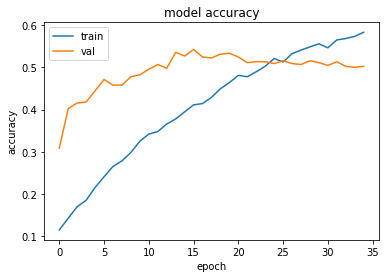

In [146]:
plt.plot(learner.history.history['accuracy'])
plt.plot(learner.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

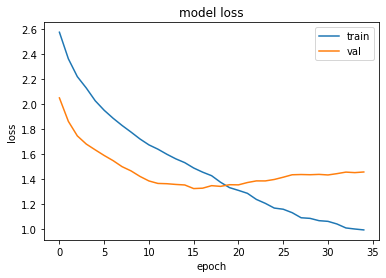

In [147]:
plt.plot(learner.history.history['loss'])
plt.plot(learner.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [148]:
predictor = ktrain.get_predictor(model2, preproc=preproc2)
predictor.save('text_only')

In [150]:
learner.evaluate()

              precision    recall  f1-score   support

           0       0.20      0.18      0.19        55
           1       0.18      0.16      0.17        45
           2       0.45      0.45      0.45        64
           3       0.17      0.14      0.15        44
           4       0.69      0.55      0.61        66
           5       0.93      0.93      0.93        74
           6       0.56      0.77      0.65        44
           7       0.47      0.60      0.53        58

    accuracy                           0.50       450
   macro avg       0.46      0.47      0.46       450
weighted avg       0.49      0.50      0.49       450



array([[10,  5,  6, 11,  0,  0,  2, 21],
       [ 3,  7, 10,  7,  3,  2,  5,  8],
       [17,  5, 29,  7,  5,  0,  1,  0],
       [10,  5,  9,  6,  5,  1,  4,  4],
       [ 1,  8,  5,  0, 36,  2,  9,  5],
       [ 0,  0,  0,  0,  0, 69,  5,  0],
       [ 2,  4,  1,  0,  2,  0, 34,  1],
       [ 8,  5,  4,  4,  1,  0,  1, 35]], dtype=int64)